In [2]:
import numpy as np
from scipy.linalg import eig
from scipy.optimize import minimize,rosen_der
import matplotlib.pyplot as plt
from numpy import array

In [35]:
# Constants and matrices definitions
GZ_F = 1.1668 * 1e-5 # Fermi constant in GeV^-2 determined in Z decay
mH =  1000  # Mass of new charged doublet Higgs in GeV
mS =  200  # Mass of new charged singlet Higgs in GeV
me = 0.511 * 10**6  # Electron mass in eV
mmu = 106 * 10**6  # Muon mass in eV
mtau = 1777 * 10**6  # Tau mass in eV
c_beta =  0.1# np.cos(np.arcsin(-2*(1e-6)*246/(mH^2-mS^2))/2) # mixing angle between singlet and doublet

In [4]:
def LFV_condition(array):
    # mu to 3e
    def muto3e(array):
        return array[3]**2*(array[6]**2+array[9]**2) < 2.9*1e-21*mH**4
    
    # tau to 3e
    def tauto3e(array):
        return array[3]**2*(array[7]**2+array[10]**2) < 4.47*1e-16*mH**4
    
    # tau to 3mu
    def tauto3mu(array):
        return array[4]**2*(array[8]**2+array[11]**2) < 3.48*1e-16*mH**4
    
    # tau to mu2e
    def tautomu2e(array):
        return (array[9]**2*array[7]**2+2*array[6]**2*array[7]**2+array[6]**2*array[10]**2+2*array[9]**2*array[10]**2) < 7.45*1e-16*mH**4
    
    # tau to e2mu
    def tautoe2mu(array):
        return (array[6]**2*array[8]**2+2*array[6]**2*array[11]**2+array[9]**2*array[11]**2+2*array[9]**2*array[8]**2) < 8.45*1e-16*mH**4
    
    # tau to 2mue
    def tauto2mue(array):
        return ((2*array[8]*array[9]-array[7]*array[4])**2+(2*array[11]*array[6]-array[10]*array[4])**2+4*array[6]**2*array[8]**2+4*array[11]**2*array[9]**2+7*array[7]**2*array[4]**2+7*array[10]**2*array[4]**2) < 2.69*1e-15*mH**4
    
    # tau to 2emu
    def tauto2emu(array):
        return ((2*array[7]*array[6]-array[8]*array[3])**2+(2*array[10]*array[9]-array[11]*array[3])**2+4*array[7]**2*array[9]**2+4*array[6]**2*array[10]**2+7*array[8]**2*array[3]**2+7*array[11]**2*array[3]**2) < 1.79*1e-15*mH**4
    
    return muto3e(array) and tauto3e(array) and tauto3mu(array) and tautomu2e(array) and tautoe2mu(array) and tauto2mue(array) and tauto2emu(array)

In [36]:
def Michel_condition(array):
    msinglet2 = (c_beta**2/(mS**2)+(1-c_beta**2)/(mH**2))**-1
    mdoublet2 = (c_beta**2/(mH**2)+(1-c_beta**2)/(mS**2))**-1
    Doublet_sum = 1/(16*mdoublet2**2)*sum(array[i] * array[j] for i in [4, 6, 11] for j in [3, 9, 10])
    a_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/8*((-array[2]*array[3]-array[0]*array[10])**2)# +(array[0]*array[10]+array[2]*array[3])**2) # a_(L=-2)
    a_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/8*((-array[0]*array[11]+array[4]*array[1])**2)# +(-array[1]*array[4]+array[11]*array[0])**2)# a_(L=2)
    c_1 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/8*((-array[2]*array[3]+array[0]*array[10])**2) # c_(L=-2)
    c_2 = (1/mS**2-1/mH**2)**2*c_beta**2 * (1 - c_beta**2)/8*((-array[0]*array[11]-array[4]*array[1])**2) # c_(L=-2)
    a = a_1+a_2
    a_prime = a_1 - a_2
    b = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)+Doublet_sum
    b_prime = (np.sqrt(2)*GZ_F+ array[0]**2/(4*msinglet2))**2 + 1/(16*msinglet2**2)*(sum(array[i]**2 * array[j]**2 for i in [0,2] for j in [0,1])-array[0]**2 * array[0]**2)-Doublet_sum
    c = c_1 + c_2
    c_prime = c_2 - c_1 

    def de_rho(array):
        return -47 * 1e-5 < 3*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[4,1,11,0],[11,1,11,1]])
                                                                                        +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                        -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2],[3,2,10,0]])) < 5 * 1e-5

    def de_delta(array):
        return  1.3 * 1e-4 < 21*(1/(mS**2)-1/(mH**2))**2/(-3*a_prime+4*b_prime-14*c_prime)*c_beta**2*(1-c_beta**2)/16*(sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[4,1,11,0],[11,1,11,1]])
                                                                                                                 -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                                 +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2],[3,2,10,0]])) < 8.1 * 1e-4
    
    def de_xi(array):
        return 2 * 1e-4 < (8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)/8*sum(array[i]**2 * array[j]**2 for i in [0,1] for j in [4,6,11])
                            + 8*(1/(mS**2)-1/(mH**2))**2/(a+4*b+6*c)*c_beta**2*(1-c_beta**2)**2/16*(3/2*sum(array[i] * array[j] * array[k] * array[l] for i,j,k,l in [[4,0,4,0],[11,0,4,1],[4,1,11,0],[11,1,11,1]])
                                                                                                    -sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[3,0,3,0],[10,2,10,2]])
                                                                                                    +sum(array[i] * array[j]*array[k] * array[l]for i,j,k,l in [[10,0,3,2],[3,2,10,0]])) 
                            +2*Doublet_sum/(a+4*b+6*c)) < 25 * 1e-4
    return  de_rho(array) and de_delta(array)  and de_xi(array)


In [6]:
def filter_and_sort(arrays, condition):
    """
    Filters and sorts a list of 12-element arrays based on a given condition.

    Parameters:
        arrays (list): List of 12-element arrays to be filtered and sorted.
        condition (function): A function defining the condition for filtering.

    Returns:
        list: Filtered and sorted list of arrays.
    """
    satisfying_arrays = [array for array in arrays if condition(array)]
    return  satisfying_arrays # sorted(satisfying_arrays, key=lambda x: sum(x))  # Sorting by sum of elements

In [74]:
def read_arrays_from_text_file(filename):
    """
    Reads arrays from a text file where each array has 12 elements.

    Parameters:
        filename (str): Name of the file to read.

    Returns:
        list: List of arrays read from the file.
    """
    arrays = []
    with open(filename, 'r') as file:
        array_data = []
        for line in file:
            array_data.extend(map(float, line.strip().split()))
            if len(array_data) == 12:
                arrays.append(np.array(array_data))
                array_data = []
    return arrays

# Example usage
filename = 'Coupling Data e-0 e-6 s_2beta e-7 mH 1 TEV.txt'
Solution= read_arrays_from_text_file(filename)
# Transform tuple to list of arrays
Solution = np.array([np_array.tolist() for np_array in Solution])

# $c_\beta = 0.1$

In [29]:
Data = np.concatenate((Data,Solution))

In [31]:
filtered_sorted_arrays_LFV = filter_and_sort(Data, LFV_condition)
print("LFV Solutions:", len(filtered_sorted_arrays_LFV))

LFV Solutions: 780


In [37]:
filtered_sorted_arrays_Michel = filter_and_sort(Data, Michel_condition)
print("Michel Solutions:", len(filtered_sorted_arrays_Michel))

Michel Solutions: 0


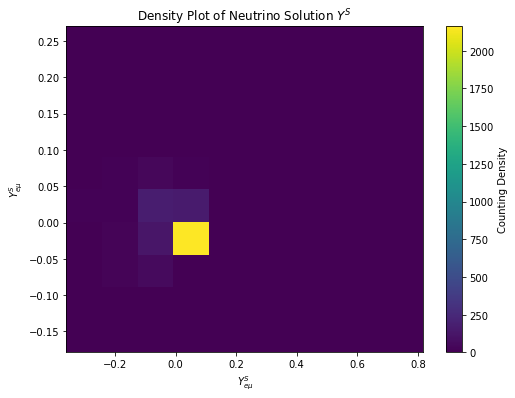

In [47]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data[:, 0], Data[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

In [ ]:
# Extract the first two elements for each array
first_two_elements = list(Data) # Data[:, :2]
# Refine the plot data into specific range
Data_0 = list(first_two_elements)
m = 0
for i in range(len(first_two_elements)):
    if abs(first_two_elements[i][0])> 1e-7 or  abs(first_two_elements[i][1])> 1e-7:
        Data_0 = np.delete(Data_0, i-m, axis=0)
        m+=1

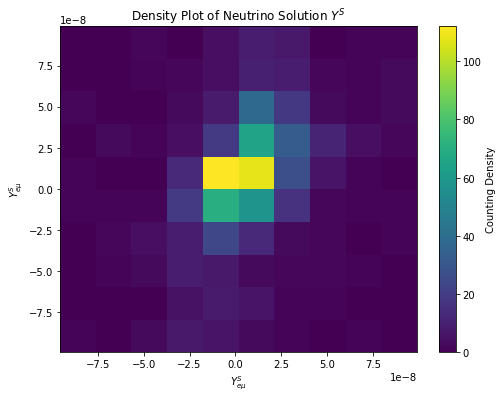

In [56]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data_0[:, 0], Data_0[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

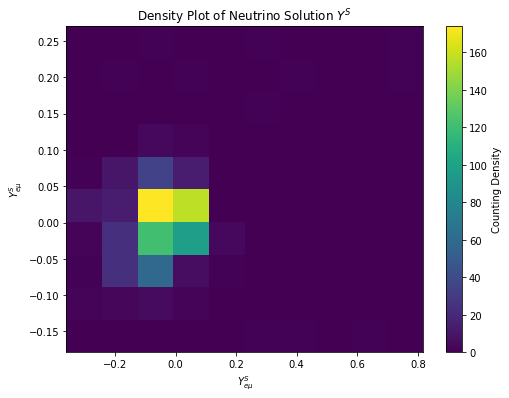

In [59]:
filtered_sorted_arrays_LFV = np.array([np_array.tolist() for np_array in filtered_sorted_arrays_LFV])
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(filtered_sorted_arrays_LFV[:, 0], filtered_sorted_arrays_LFV[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

In [64]:
# Extract the first two elements for each array
first_two_elements = list(filtered_sorted_arrays_LFV) # Data[:, :2]
# Refine the plot data into specific range
Data_1 = list(first_two_elements)
m = 0
for i in range(len(first_two_elements)):
    if abs(first_two_elements[i][0])> 1e-1 or  abs(first_two_elements[i][1])> 1e-1:
        Data_1 = np.delete(Data_1, i-m, axis=0)
        m+=1

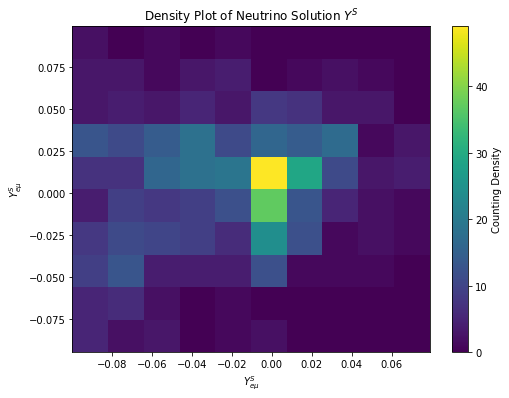

In [65]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Data_1[:, 0], Data_1[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.1$')
plt.show()

# $c_\beta =0.5$

In [72]:
filtered_sorted_arrays_LFV = filter_and_sort(Solution, LFV_condition)
print("LFV Solutions:", len(filtered_sorted_arrays_LFV))

LFV Solutions: 95


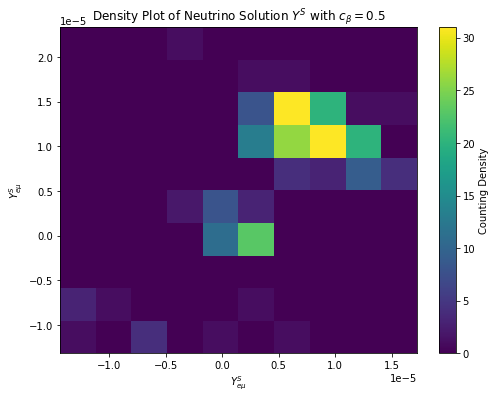

In [68]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Solution[:, 0], Solution[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ with $c_\\beta = 0.5$')
plt.show()

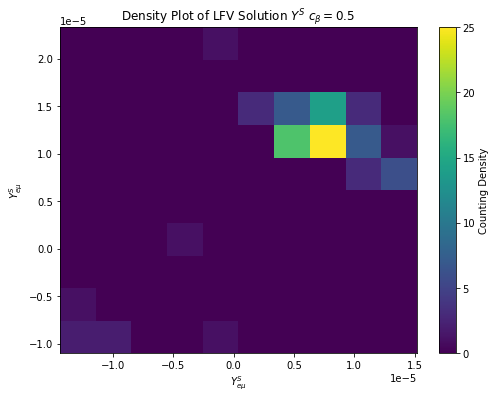

In [73]:
filtered_sorted_arrays_LFV = np.array([np_array.tolist() for np_array in filtered_sorted_arrays_LFV])
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(filtered_sorted_arrays_LFV[:, 0], filtered_sorted_arrays_LFV[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $c_\\beta = 0.5$')
plt.show()

# $s_{2\beta} = 10^{-7}$

In [79]:
mH=10000 # 10 TeV set mass of the new neutral Higgs

In [80]:
filtered_sorted_arrays_LFV = filter_and_sort(Solution, LFV_condition)
print("LFV Solutions:", len(filtered_sorted_arrays_LFV))

LFV Solutions: 17


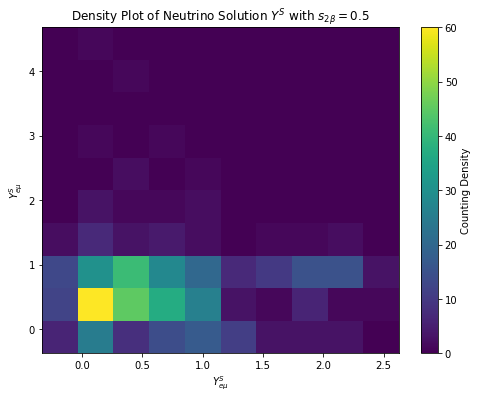

In [81]:
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(Solution[:, 0], Solution[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of Neutrino Solution $Y^S$ with $s_{2\\beta} = 10^{-7}$')
plt.show()

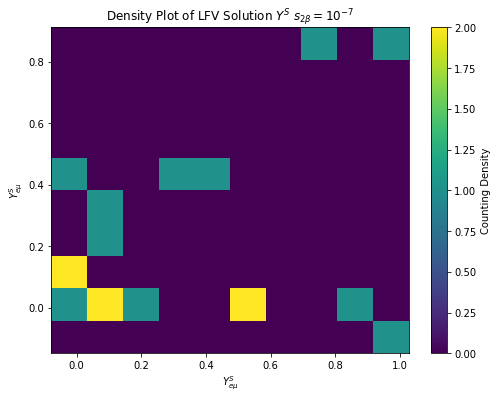

In [82]:
filtered_sorted_arrays_LFV = np.array([np_array.tolist() for np_array in filtered_sorted_arrays_LFV])
# Plot the density
plt.figure(figsize=(8, 6))
plt.hist2d(filtered_sorted_arrays_LFV[:, 0], filtered_sorted_arrays_LFV[:, 1], bins=10, cmap='viridis')

# Set log scale and value ranges for the axes
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(-1e-6, 1e-6)  # Set x-axis limit from 10^-3 to 1
# plt.ylim(-1e-6, 1e-6)  # Set y-axis limit from 10^-3 to 1

plt.colorbar(label='Counting Density')
plt.xlabel("$Y^S_{e \\mu}$")
plt.ylabel("$Y^S_{e \\mu}$")
plt.title('Density Plot of LFV Solution $Y^S$ $s_{2\\beta} = 10^{-7}$')
plt.show()